In [2]:
import os
os.environ["PYTHONPATH"] = "/home/novomics/work/TEA-graph:" + os.environ.get("PYTHONPATH", "")
os.environ.get("PYTHONPATH")

'/home/novomics/work/TEA-graph:/work/Superpatch_network_construction'

In [20]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import torch
import openslide as osd
from torchvision import transforms
from torch_geometric.data import Data
# from Superpatch_network_construction.EfficientNet import EfficientNet
# from Superpatch_network_construction.superpatch_network_construction import false_graph_filtering
from EfficientNet import EfficientNet
from superpatch_network_construction import false_graph_filtering
from skimage.filters import threshold_multiotsu
from matplotlib import pyplot as plt
import pickle
import argparse
import tifffile as tiff
from PIL import Image

Loaded pretrained weights for efficientnet-b4


['../Sample_data_for_demo/Novomics_TIF_Raw_WSI/.ipynb_checkpoints',
 '../Sample_data_for_demo/Novomics_TIF_Raw_WSI/T04-SHCN0046.tif']

../Sample_data_for_demo/Novomics_TIF_Raw_WSI/T04-SHCN0046.tif: mpp:1 / scaling_factor:0.5


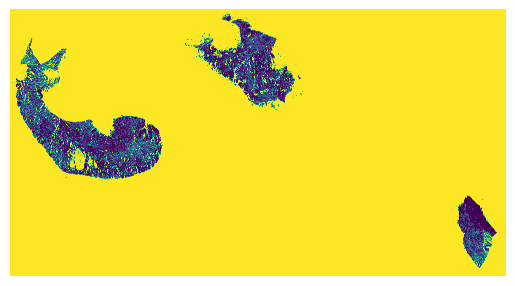

512

  0% 0/18216 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 23% 4118/18216 [00:02<00:06, 2015.64it/s]


In [34]:
device = torch.device(int('0') if torch.cuda.is_available() else "cpu")
model_ft = EfficientNet.from_pretrained('efficientnet-b4', num_classes = 2)
model_ft = model_ft.to(device)
model_ft.eval()

image_dir = '../Sample_data_for_demo/Novomics_TIF_Raw_WSI'
files = files = os.listdir(image_dir)
final_files = [os.path.join(image_dir, file) for file in files]
final_files.sort(key=lambda f: os.stat(f).st_size, reverse=False)
display(final_files)

threshold =0.75
spatial_threshold = 5.5

def resize_tif_as_target_mpp(tif, target_mpp=2.0):
    image = tif.asarray()
    
    try:
        current_mpp = tif.pages[0].tags['XResolution'].value[1]
        scaling_factor = current_mpp / target_mpp
    except:
        raise Exception('Error getting properties (Resolution)')
    
    resized_image = Image.fromarray(image).resize((int(image.shape[1] * scaling_factor), int(image.shape[0] * scaling_factor)))
    print(f'mpp:{current_mpp} / scaling_factor:{scaling_factor}')
    return resized_image, scaling_factor

def supernode_generation(image, model_ft=model_ft, device=device, 
                         Argument={'threshold': 0.75, 'spatial_threshold': 5.5, 'imagesize':256}):
    transform = transforms.Compose([
                transforms.Resize(320),
                transforms.CenterCrop(299),
                transforms.ToTensor(),
                transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
                ])   
    
    threshold = Argument.get('threshold')
    spatial_threshold = Argument.get('spatial_threshold')

    with tiff.TiffFile(image) as tif:
        print(f'{image}:', end=' ')
        resized_image, scaling_factor = resize_tif_as_target_mpp(tif)
        
        tif_native_arr = tif.asarray()
        tif_native_img = Image.fromarray(np.uint8(tif_native_arr)).convert('L')
        img = np.array(tif_native_img)

        thresholds = threshold_multiotsu(img)
        regions = np.digitize(img, bins=thresholds)
        regions[regions == 1] = 0
        regions[regions == 2] = 1
        thresh_otsu = regions
        
        plt.imshow(thresh_otsu)
        plt.axis('off')
        plt.show()
        
        imagesize = Argument.get('imagesize')
        resampled_size = int(imagesize / scaling_factor)
        display(resampled_size)
        
        Height, Width, _ = tif.pages[0].shape
        # Height = tif.pages[0].image_height
        num_row = int(Height/imagesize) + 1
        num_col = int(Width/imagesize) + 1
        x_list = []
        y_list = []
        feature_list = []
        x_y_list = []
        counter = 0
        inside_counter = 0
        temp_patch_list = []
        temp_x = []
        temp_y = []
        
        with tqdm(total = num_row * num_col) as pbar_image:
            for i in range(0, num_col):
                for j in range(0, num_row):
                    
                    if thresh_otsu.shape[1] >= (i+1)*resampled_size:
                        if thresh_otsu.shape[0] >= (j+1)*resampled_size:
                            cut_thresh = thresh_otsu[j*resampled_size:(j+1)*resampled_size, i*resampled_size:(i+1)*resampled_size]
                        else:
                            cut_thresh = thresh_otsu[(j)*resampled_size:thresh_otsu.shape[0], i*resampled_size:(i+1)*resampled_size]
                    else:
                        if thresh_otsu.shape[0] >= (j+1)*resampled_size:
                            cut_thresh = thresh_otsu[j*resampled_size:(j+1)*resampled_size, (i)*resampled_size:thresh_otsu.shape[1]]
                        else:
                            cut_thresh = thresh_otsu[(j)*resampled_size:thresh_otsu.shape[0], (i)*resampled_size:thresh_otsu.shape[1]]
                             
                    if np.mean(cut_thresh) > 0.75:
                        pbar_image.update()
                        pass
    # plt.imshow(resized_image)
    # plt.axis('off')
    # plt.show()
    

supernode_generation(final_files[1])